In [14]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
torch.set_default_device(device)
torch.manual_seed(42)

device

'cuda'

In [15]:
import random
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, ConcatDataset

generator = torch.Generator(device=device)
# Define augmentation transforms
rotation_degrees = 20
translation_percent = 0.1
validation_ratio = 0.2

transform_list = [
    transforms.RandomRotation(degrees=(-rotation_degrees, rotation_degrees)),
    transforms.RandomAffine(degrees=0, translate=(translation_percent, translation_percent)),
    transforms.RandomVerticalFlip(p=0.5),
    
]

# Path and configurations
data_dir = "./TRAIN/"
batch_size = 400

# Original dataset without augmentation
original_dataset = ImageFolder(root=data_dir, transform=transforms.ToTensor())

augmented = []
for index, (data, label) in enumerate(original_dataset):
    images = []
    for transform in transform_list:
        if random.random() > 0.15:
            transformed_data = transform(data)
            images.append(transformed_data)
            if len(images) >= 2 and random.random() > 0.50:
                transformed_data = transform(images[-2])
                images.append(transformed_data)
    else:
        for image in images:  augmented.append((image, label))
        
        
        

class AugmentedCustomDataset(Dataset):
    def __init__(self, augmented_data):
        self.augmented_data = augmented_data

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        images, label = self.augmented_data[idx]
        tensor_images = [torch.Tensor(image) for image in images]
        combined_images = torch.stack(tensor_images)
        
        return combined_images, label

custom_augmented_dataset = AugmentedCustomDataset(augmented)
combined_dataset = torch.utils.data.ConcatDataset([original_dataset, custom_augmented_dataset])

val_size = int(len(combined_dataset) * validation_ratio)
train_size = int(len(combined_dataset) - val_size)


In [16]:
generator = torch.Generator(device=device)
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size], generator=generator)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=250, shuffle=True,generator=torch.Generator(device='cuda'))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=250, shuffle=False,generator=torch.Generator(device='cuda'))

In [17]:


data_dir = './TUNE/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
custom_dataset = ImageFolder(root=data_dir, transform=data_transforms)

batch_size = 400 
val_size = int(len(custom_dataset) * 0.3)
train_size = int(len(custom_dataset) - val_size)


generator = torch.Generator(device=device)
train_dataset_ft, val_dataset_ft = torch.utils.data.random_split(custom_dataset, [train_size, val_size],generator=generator)
train_loader_ft = torch.utils.data.DataLoader(train_dataset_ft, batch_size=10, shuffle=True,generator=torch.Generator(device='cuda'))
val_loader_ft = torch.utils.data.DataLoader(val_dataset_ft, batch_size=10, shuffle=False,generator=torch.Generator(device='cuda'))

In [18]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class CustomDecoder(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomDecoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.dconv1 = DepthwiseSeparableConv(32, 64, kernel_size=3, stride=1, padding=1)
        self.dconv2 = DepthwiseSeparableConv(64, 128, kernel_size=3, stride=2, padding=1)
        self.dconv3 = DepthwiseSeparableConv(128, 128, kernel_size=3, stride=1, padding=1)
        self.dconv4 = DepthwiseSeparableConv(128, 256, kernel_size=3, stride=2, padding=1)
        self.dconv5 = DepthwiseSeparableConv(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.dconv6 = DepthwiseSeparableConv(256, 512, kernel_size=3, stride=2, padding=1)
        self.fivex_dconv = nn.ModuleList([DepthwiseSeparableConv(512, 512, kernel_size=3, stride=1, padding=1) for _ in range(5)])
        
        self.dconv7 = DepthwiseSeparableConv(512, 1024, kernel_size=3, stride=2, padding=1)
        self.dconv8 = DepthwiseSeparableConv(1024, 1024, kernel_size=3, stride=1, padding=1)
        
        self.dropout_dense = nn.Dropout(p=0.3)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dconv1(x)
        x = self.dconv2(x)
        x = self.dconv3(x)
        x = self.dconv4(x)
        x = self.dconv5(x)
        x = self.dconv6(x)
        for dconv_layer in self.fivex_dconv: x = dconv_layer(x)   
        x = self.dconv7(x)
        x = self.dconv8(x)
        x = self.global_avg_pool(x)
        x = self.dropout_dense(x)
        x = torch.flatten(x, 1) 
        x = self.fc(x)
        return x




In [19]:
from torch import optim
alex_net = CustomDecoder().to(device).float()
optimizer = optim.Adam(alex_net.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()

In [20]:
num_epochs = 24

metrics_train = {
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}
for epoch in range(num_epochs):
    alex_net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alex_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    alex_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alex_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    metrics_train['train_accuracy'].append(train_accuracy)
    metrics_train['val_accuracy'].append(val_accuracy)
    metrics_train['train_loss'].append(epoch_loss)
    metrics_train['val_loss'].append(epoch_val_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")

Epoch [1/24] - Loss: 1.9805 - Val Loss: 1.8293 - Train Acc: 19.89% - Val Acc: 24.90%
Epoch [2/24] - Loss: 1.7059 - Val Loss: 1.6819 - Train Acc: 30.72% - Val Acc: 32.24%
Epoch [3/24] - Loss: 1.5162 - Val Loss: 1.5418 - Train Acc: 39.82% - Val Acc: 39.62%
Epoch [4/24] - Loss: 1.3151 - Val Loss: 1.4756 - Train Acc: 48.99% - Val Acc: 42.88%
Epoch [5/24] - Loss: 1.1395 - Val Loss: 1.5224 - Train Acc: 57.02% - Val Acc: 44.96%
Epoch [6/24] - Loss: 0.9711 - Val Loss: 1.4193 - Train Acc: 63.94% - Val Acc: 48.82%
Epoch [7/24] - Loss: 0.8418 - Val Loss: 1.5783 - Train Acc: 69.19% - Val Acc: 45.45%
Epoch [8/24] - Loss: 0.6709 - Val Loss: 1.3573 - Train Acc: 75.94% - Val Acc: 54.09%
Epoch [9/24] - Loss: 0.5583 - Val Loss: 1.4076 - Train Acc: 80.02% - Val Acc: 57.06%
Epoch [10/24] - Loss: 0.4519 - Val Loss: 1.4831 - Train Acc: 84.11% - Val Acc: 56.01%
Epoch [11/24] - Loss: 0.3672 - Val Loss: 1.6030 - Train Acc: 87.19% - Val Acc: 55.63%
Epoch [12/24] - Loss: 0.2965 - Val Loss: 1.5667 - Train Acc: 89

In [21]:
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001) 

In [22]:
num_epochs = 24

metrics_train = {
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}
for epoch in range(num_epochs):
    alex_net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alex_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    alex_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alex_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    metrics_train['train_accuracy'].append(train_accuracy)
    metrics_train['val_accuracy'].append(val_accuracy)
    metrics_train['train_loss'].append(epoch_loss)
    metrics_train['val_loss'].append(epoch_val_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")

Epoch [1/24] - Loss: 0.0373 - Val Loss: 1.6149 - Train Acc: 98.88% - Val Acc: 66.29%
Epoch [2/24] - Loss: 0.0064 - Val Loss: 1.6203 - Train Acc: 99.94% - Val Acc: 66.48%
Epoch [3/24] - Loss: 0.0038 - Val Loss: 1.6437 - Train Acc: 99.97% - Val Acc: 66.36%
Epoch [4/24] - Loss: 0.0030 - Val Loss: 1.6742 - Train Acc: 99.96% - Val Acc: 66.81%
Epoch [5/24] - Loss: 0.0026 - Val Loss: 1.6923 - Train Acc: 99.96% - Val Acc: 66.61%
Epoch [6/24] - Loss: 0.0021 - Val Loss: 1.7215 - Train Acc: 99.97% - Val Acc: 66.70%
Epoch [7/24] - Loss: 0.0019 - Val Loss: 1.7371 - Train Acc: 99.97% - Val Acc: 66.65%
Epoch [8/24] - Loss: 0.0014 - Val Loss: 1.7534 - Train Acc: 99.97% - Val Acc: 66.91%
Epoch [9/24] - Loss: 0.0016 - Val Loss: 1.7637 - Train Acc: 99.96% - Val Acc: 66.91%
Epoch [10/24] - Loss: 0.0011 - Val Loss: 1.7748 - Train Acc: 99.98% - Val Acc: 67.09%
Epoch [11/24] - Loss: 0.0014 - Val Loss: 1.7914 - Train Acc: 99.95% - Val Acc: 66.90%
Epoch [12/24] - Loss: 0.0011 - Val Loss: 1.7998 - Train Acc: 99

Classification Report:
              precision    recall  f1-score   support

     class_0       0.26      0.48      0.34        42
     class_1       0.29      0.46      0.36        52
     class_2       0.26      0.25      0.26        59
     class_3       0.37      0.51      0.43        69
     class_4       0.94      0.49      0.64        70
     class_5       0.52      0.29      0.37        59
     class_6       0.34      0.32      0.33        68
     class_7       0.27      0.15      0.19        61

    accuracy                           0.37       480
   macro avg       0.41      0.37      0.36       480
weighted avg       0.42      0.37      0.37       480



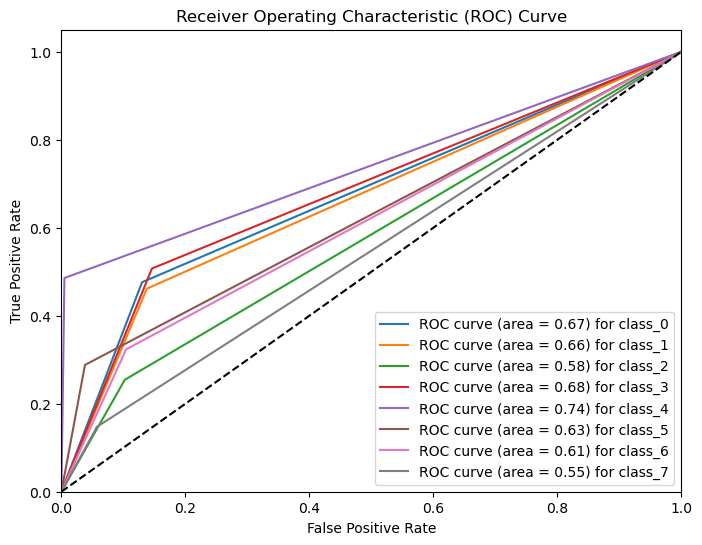

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = []  # Ground truth
y_pred = []
with torch.no_grad():
        for inputs, labels in val_loader_ft:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alex_net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7']
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(classification_rep)

cm = confusion_matrix(y_true, y_pred)


# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
num_classes = len(class_names)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

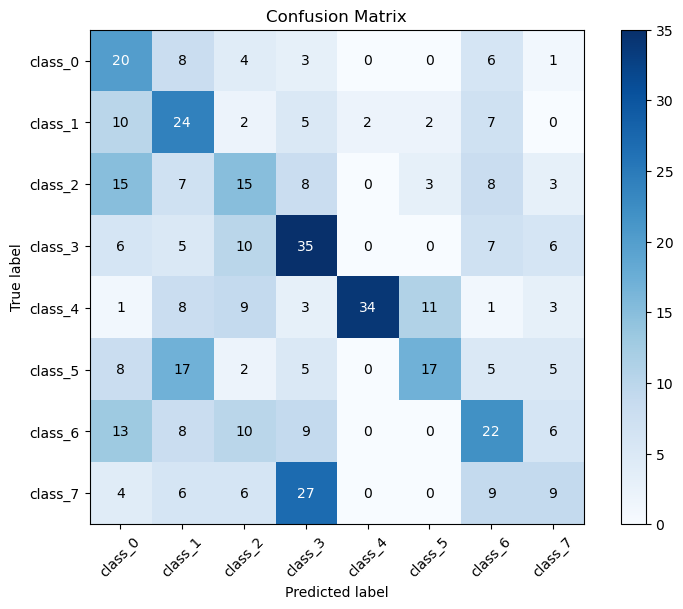

In [24]:
 # Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()